# Project Title: Solar Radiation Forecasting [notebook '03_ML_DL_Models.ipynb']

## Authors: Denys Herasymuk & Yaroslav Morozevych

## Contents of This Notebook

Click on the section and go to this cell immediately.

* [Section 1. Nonstationary-to-Stationary Transformations](#section_1)
* [Section 2. Feature generation and validation of SARIMAX model](#section_2)
* [Section 3. Validate DL and ML models](#section_3)


**How to run this notebook**

* Create a new conda env with python 3.7
* Run `jupyter notebook` in your new env via terminal (without installing any packages now)
* run these two cells in your jupyter:
```
!conda install -c conda-forge tensorboard -y
!pip install --upgrade plotly
```

* In terminal run  -- `pip install -r requirements.txt`
* In any case, a useful command -- `conda create --clone py35 --name py35-2` from here -- https://docs.conda.io/projects/conda/en/4.6.0/_downloads/52a95608c49671267e40c689e0bc00ca/conda-cheatsheet.pdf

## General Configuration

In [ ]:
# For Google Colab
!pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import math
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import tensorflow as tf
import statsmodels as ss
import matplotlib.pyplot as plt

import xgboost
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector

from pprint import pprint
from datetime import datetime, timedelta, date
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# from constants import *
# from utils import run_simple_sequence_plot

Below section is just for Google Colab

In [ ]:
FORECAST_PERIOD = 24 * 3 # 3 days
DECOMPOSED_SHIFT = FORECAST_PERIOD // 2 + (FORECAST_PERIOD // 2) % 24  # round to the closest number of days

FEATURES_LAGS = [24 * 2 + 24 * i for i in range(1, 4)]
RADIATION_LAGS = [24 * 2 + 24 * i for i in range(1, 4)]
RECENT_RADIATION_LAGS = [i for i in range(1, 6)]
MAX_DF_SHIFT = max(FEATURES_LAGS + RADIATION_LAGS)
GCOLAB_HOME_DIR = '/content/drive/MyDrive/Colab Notebooks/UCU_ML_2022/UCU_Machine_Learning_Course_Project'

def run_simple_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
  

Use below cell in case you train models on GPU

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
%matplotlib inline

alt.data_transformers.disable_max_rows()
alt.renderers.enable('html')

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

## Python & Library Versions

In [ ]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("statsmodels", ss.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__),
             ("keras", keras.__version__),
             ("xgboost", xgboost.__version__),
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.2.2
numpy       1.21.6
pandas      1.3.5
statsmodels 0.12.2
seaborn     0.11.2
sklearn     1.0.2
keras       2.8.0
xgboost     0.90


## Inspect Dataset

In case you train models in Google Colab, use the below cell to connect to your Google Drive with datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# hourly_radiation_df = pd.read_csv(os.path.join("..", "data", "dataset1_HourlySolarRadiationProcessed.csv"))

# For Google Colab here is a path to dataset on Google Drive
hourly_radiation_df = pd.read_csv(GCOLAB_HOME_DIR + '/data/dataset1_HourlySolarRadiationProcessed.csv')
hourly_radiation_df.head()

,Hourly_DateTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,ZenithDeviation,Year,Month,Day,Hour,Log_Radiation
0,2016-10-01 00:00:00,1.26,48.50,30.45,88.25,153.25,9.98,697.62,2016,10,1,0,0.23
1,2016-10-01 01:00:00,1.27,50.42,30.44,98.92,145.18,8.06,644.50,2016,10,1,1,0.24
2,2016-10-01 02:00:00,1.28,50.08,30.43,100.00,136.54,6.84,584.50,2016,10,1,2,0.24
3,2016-10-01 03:00:00,1.27,50.17,30.43,100.00,132.10,5.34,524.50,2016,10,1,3,0.24
4,2016-10-01 04:00:00,1.27,50.17,30.43,100.17,117.02,6.75,464.50,2016,10,1,4,0.24


In [ ]:
hourly_radiation_df.columns

Index(['Hourly_DateTime', 'Radiation', 'Temperature', 'Pressure', 'Humidity',
       'WindDirection(Degrees)', 'Speed', 'ZenithDeviation', 'Year', 'Month',
       'Day', 'Hour', 'Log_Radiation'],
      dtype='object')

In [ ]:
print(f'Data time range: from {hourly_radiation_df.Hourly_DateTime.unique().min()} to {hourly_radiation_df.Hourly_DateTime.unique().max()}')

Data time range: from 2016-10-01 00:00:00 to 2016-11-29 00:00:00


In [ ]:
hourly_radiation_df.index = pd.to_datetime(hourly_radiation_df.Hourly_DateTime)

In [ ]:
# Make dataset consistent with that is used for training ARIMA models,
# since during transformations for stationarity it became less for ARIMA training.
# It is needed to fairly compare models accuracy
hourly_radiation_df =hourly_radiation_df[hourly_radiation_df.index.min() + timedelta(hours=DECOMPOSED_SHIFT):
                                         hourly_radiation_df.index.max() - timedelta(hours=DECOMPOSED_SHIFT)]

In [ ]:
print(f'Data time range: from {hourly_radiation_df.index.unique().min()} to {hourly_radiation_df.index.unique().max()}')

Data time range: from 2016-10-03 00:00:00 to 2016-11-27 00:00:00


In [ ]:
hourly_radiation_df.drop(['Hourly_DateTime'], axis=1, inplace=True)

<a id='section_1'></a>
## Section 1. Nonstationary-to-Stationary Transformations

Let's create a few stationary time series from our non-stationary ones, to test, which of them will give us the best score.

In [ ]:
def get_polynomial_trend_prediction(trend):
    X = trend.index[:, np.newaxis]
    y = trend.values[:, np.newaxis]

    poly_reg = PolynomialFeatures(degree=3)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)
    polynomial_trend_prediction = pol_reg.predict(poly_reg.fit_transform(X))

    # Visualizing the Polymonial Regression results
    plt.scatter(X, y, color='red')
    plt.plot(X, polynomial_trend_prediction, color='blue')
    plt.ylabel('Production')
    plt.show()

    return polynomial_trend_prediction.flatten()

### Approach #1: Remove Trend & Seasonality with Statsmodels

#### Additive hypothesis

In [ ]:
ss_decomposition = seasonal_decompose(x=hourly_radiation_df.Radiation, model='additive', period=PERIOD)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

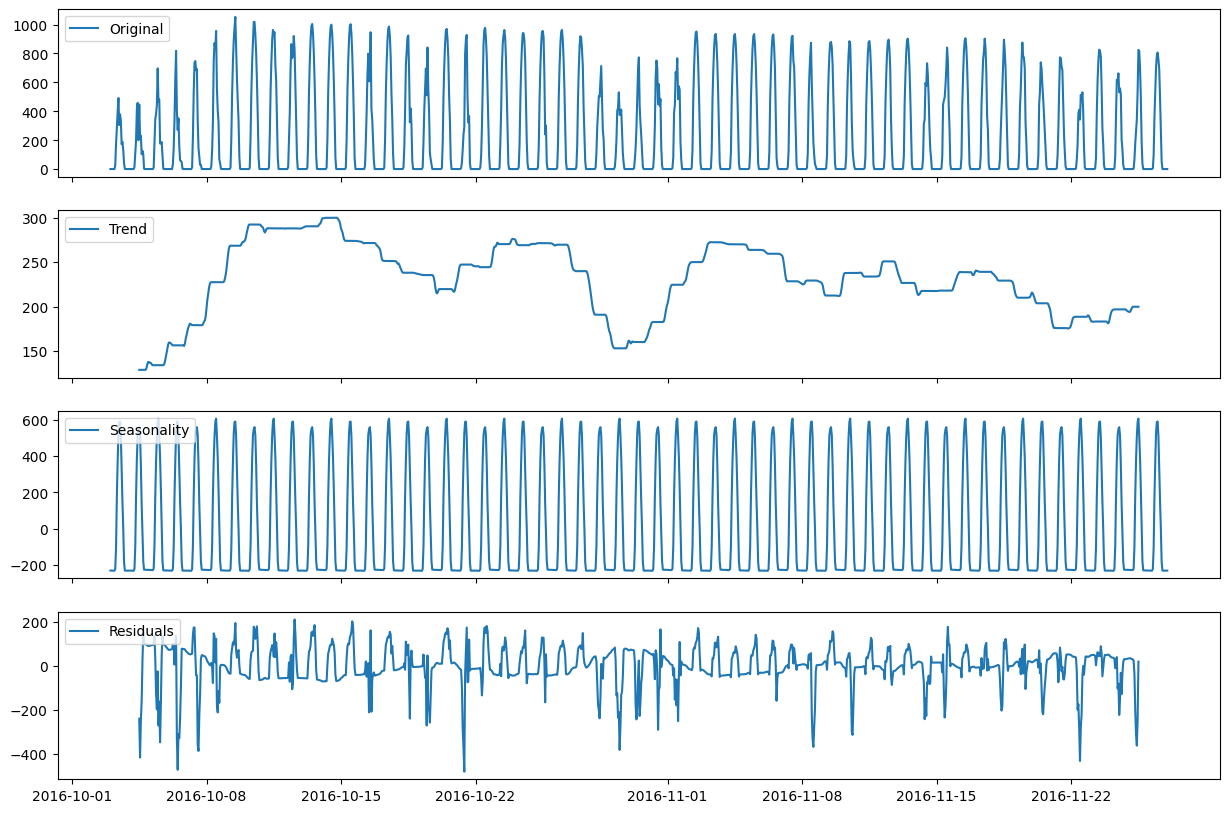

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(hourly_radiation_df.Radiation, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left')

In [ ]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -7.509677226667154
p-value:  4.046629432860791e-11


In [ ]:
additive_decomposed_radiation = estimated_residual[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT].reset_index(drop=True)
additive_decomposed_trend = estimated_trend[DECOMPOSED_SHIFT: -DECOMPOSED_SHIFT].reset_index(drop=True)
additive_decomposed_seasonal = estimated_seasonal

Great now we see from ADF test and from plots that our additive_decomposed_radiation is **stationary**. Hence, we can use it for training models. Now we need just to extrapolate our trend to make forecast out of our dataset. For seasonality we just cut a part, which is equal to its period.

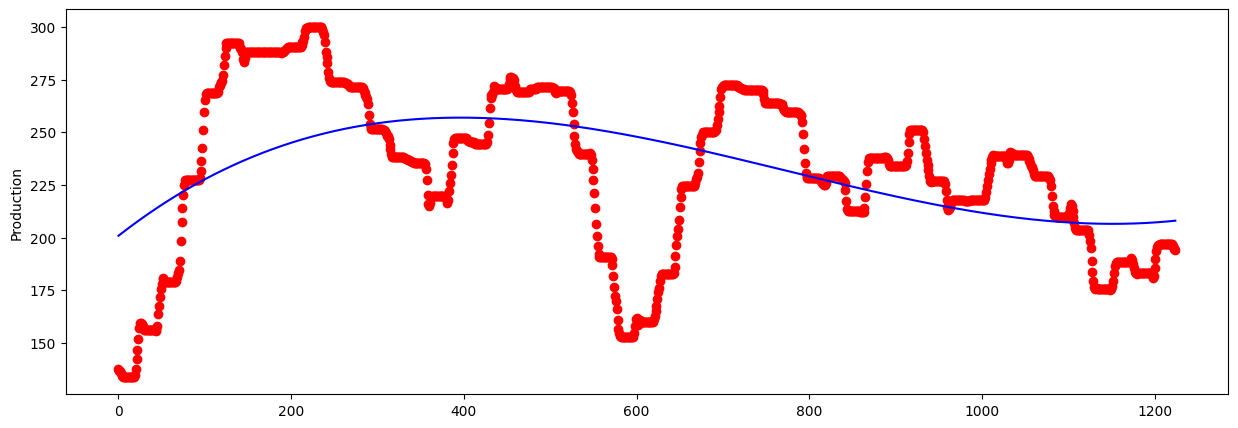

In [ ]:
additive_decomposed_trend_prediction = get_polynomial_trend_prediction(additive_decomposed_trend)

#### Multiplicative hypothesis

In [ ]:
# Used model='multiplicative' to split on trend, seasonal and residuals
ss_decomposition = seasonal_decompose(x=hourly_radiation_df.Radiation, model='multiplicative', period=PERIOD)
estimated_trend2 = ss_decomposition.trend
estimated_seasonal2 = ss_decomposition.seasonal
estimated_residual2 = ss_decomposition.resid

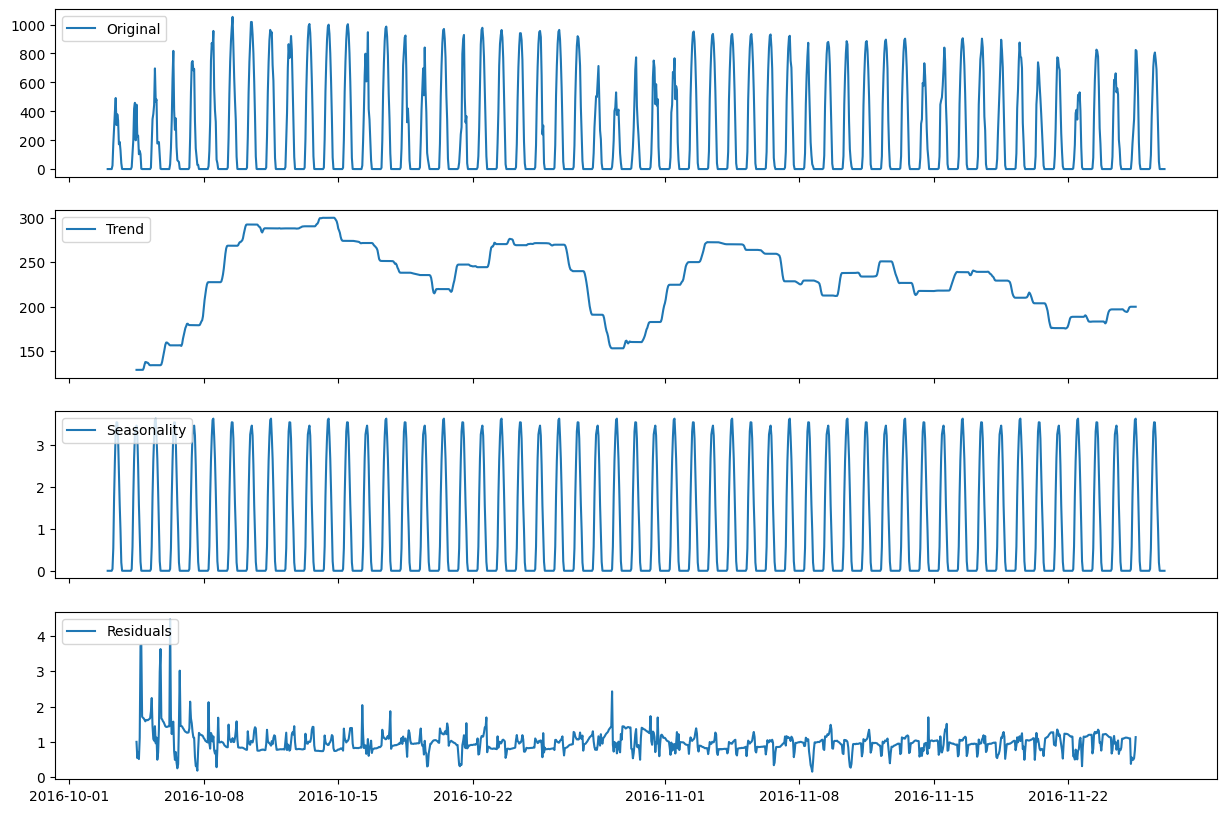

In [ ]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(hourly_radiation_df.Radiation, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend2, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal2, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual2, label='Residuals')
axes[3].legend(loc='upper left')

In [ ]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual2[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -5.150513246995877
p-value:  1.108533768412443e-05


In [ ]:
multiplicative_decomposed_radiation = estimated_residual2[DECOMPOSED_SHIFT:-DECOMPOSED_SHIFT].reset_index(drop=True)
multiplicative_decomposed_trend = estimated_trend2[DECOMPOSED_SHIFT: -DECOMPOSED_SHIFT].reset_index(drop=True)
multiplicative_decomposed_seasonal = estimated_seasonal2

In [ ]:
multiplicative_decomposed_trend.to_csv(GCOLAB_HOME_DIR + '/results/multiplicative_decomposed_trend_v1.csv')
multiplicative_decomposed_seasonal.to_csv(GCOLAB_HOME_DIR + '/results/multiplicative_decomposed_seasonal_v1.csv')

Great now we see from ADF test and from plots that our multiplicative_decomposed_radiation is **stationary**. Hence, we can use it for training models. Now we need just to extrapolate our trend to make forecast out of our dataset. For seasonality we just cut a part, which is equal to its period.

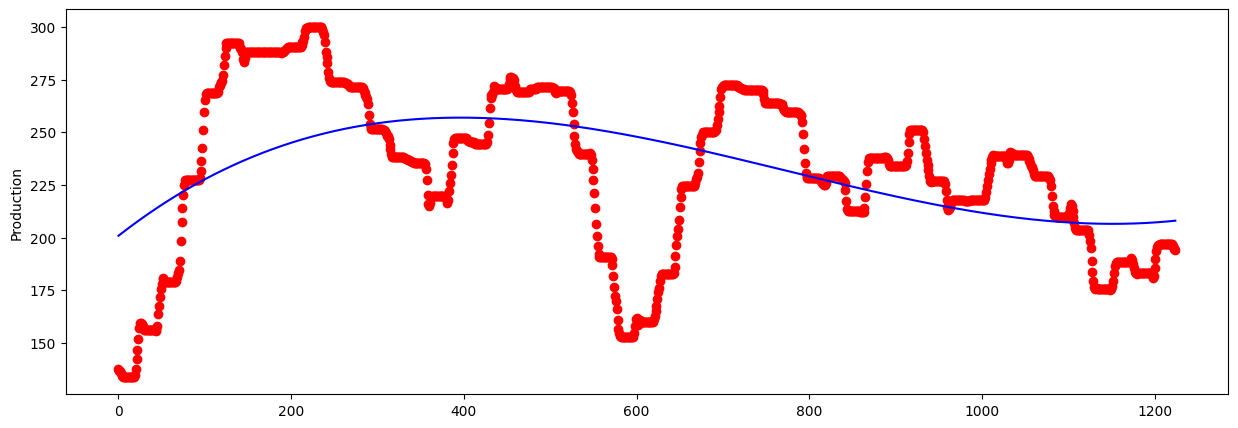

In [ ]:
multiplicative_decomposed_trend_prediction = get_polynomial_trend_prediction(multiplicative_decomposed_trend)

### Approach #2: Log Transformation

As our time series of multiplicative hypothesis was non-stationary, so this approach did not help to make our initial OtherPEN_production['Production'] stationary.

### Approach #3: Removing Autocorrelation with Differencing

Let's subtract $O_{t-1}$ from $O_{t}$ where $O_{t}$ is the observed data at time *t* and $O_{t-1}$ is the observed data at *t-1*.

#### Additive hypothesis

Here ew use differencing approach with lag = 1 (to reduce trend) and lag = 12 (to reduce sessonality).

##### First difference

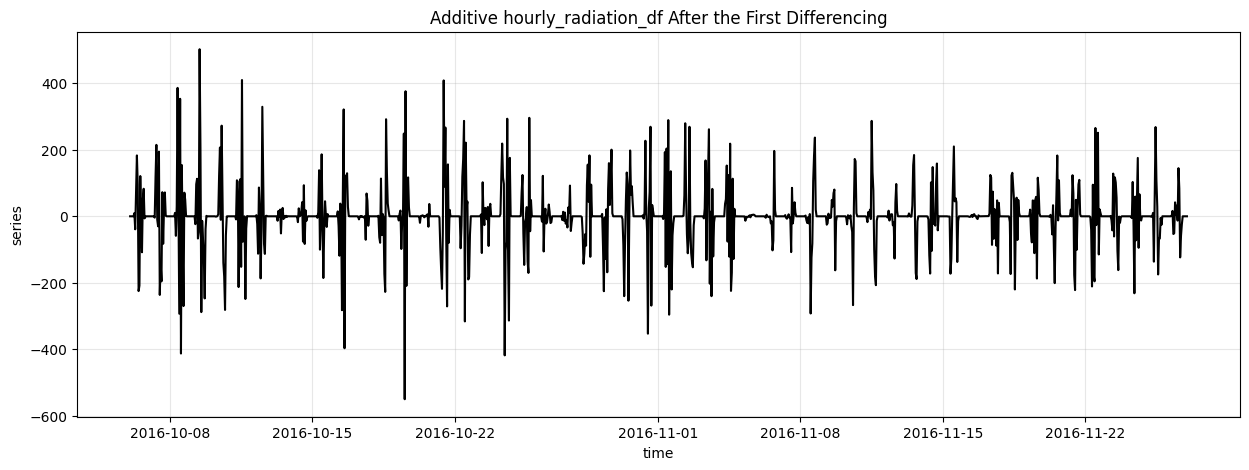

In [ ]:
additive_diff_production_1 = hourly_radiation_df.Radiation.diff(FORECAST_PERIOD).diff(1)
run_simple_sequence_plot(hourly_radiation_df.index, additive_diff_production_1,
                         title="Additive hourly_radiation_df After the First Differencing")

In [ ]:
additive_diff_production_1 = additive_diff_production_1[1 + FORECAST_PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -14.094394802714419
p-value:  2.686354976631549e-26


##### Second difference

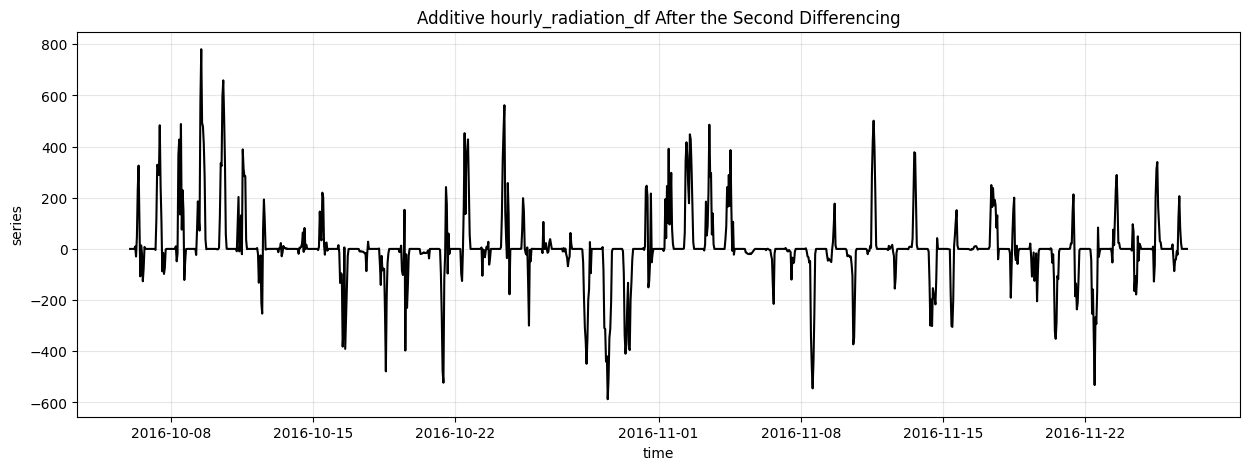

In [ ]:
additive_diff_production_12 = hourly_radiation_df.Radiation.diff(FORECAST_PERIOD)
run_simple_sequence_plot(hourly_radiation_df.index, additive_diff_production_12,
                         title="Additive hourly_radiation_df After the Second Differencing")
additive_diff_production_12 = additive_diff_production_12[FORECAST_PERIOD:].reset_index(drop=True)

In [ ]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -4.4110306885724455
p-value:  0.00028377051819241446


#### Multiplicative hypothesis

##### First difference

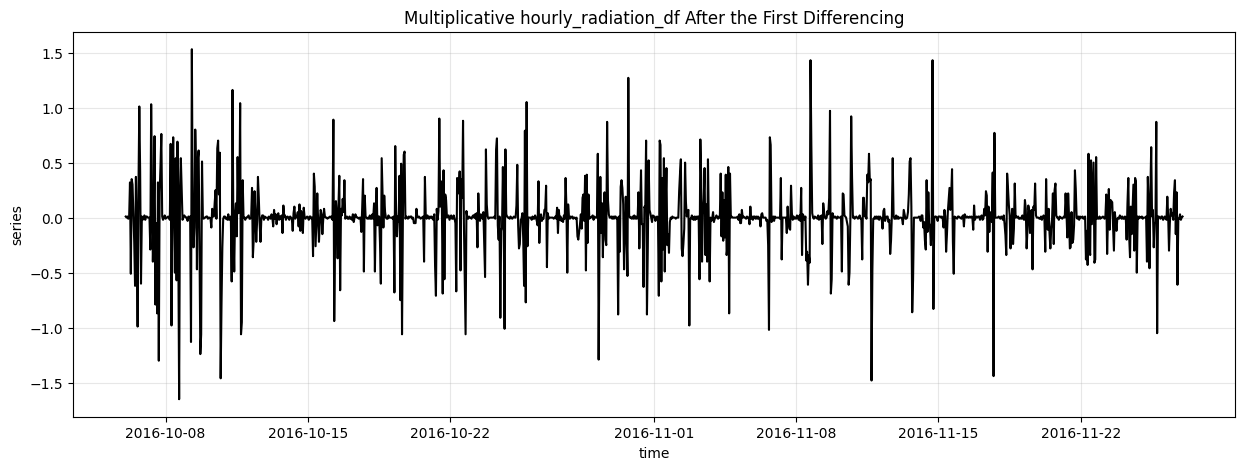

In [ ]:
multiplicative_diff_production_1 = hourly_radiation_df.Log_Radiation.diff(FORECAST_PERIOD).diff(1)

run_simple_sequence_plot(hourly_radiation_df.index, multiplicative_diff_production_1,
                         title="Multiplicative hourly_radiation_df After the First Differencing")
multiplicative_diff_production_1 = multiplicative_diff_production_1[1 + FORECAST_PERIOD:].reset_index(drop=True)

In [ ]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -14.382041301346142
p-value:  9.118681153819467e-27


##### Second difference

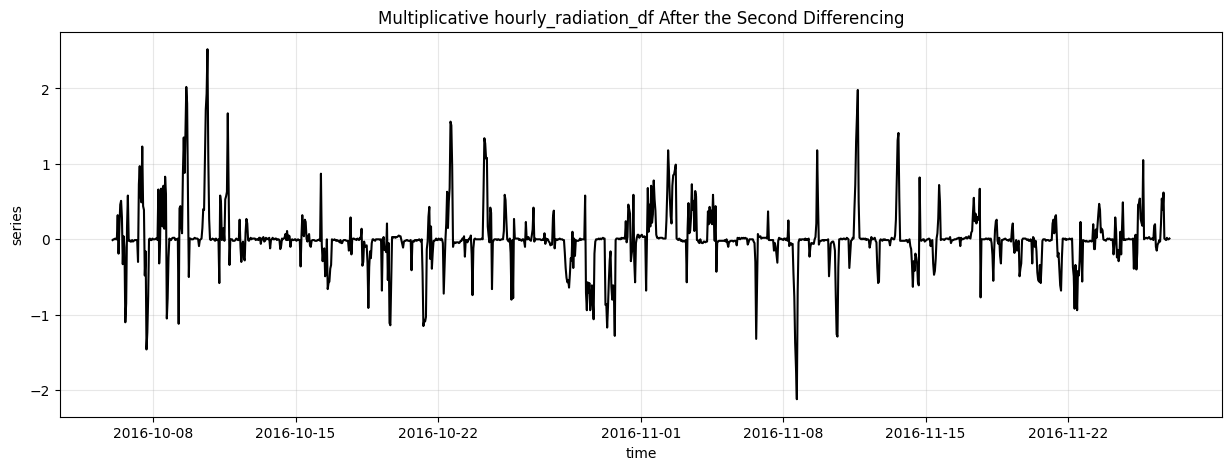

In [ ]:
multiplicative_diff_production_12 = hourly_radiation_df.Log_Radiation.diff(FORECAST_PERIOD)

run_simple_sequence_plot(hourly_radiation_df.index, multiplicative_diff_production_12,
                         title="Multiplicative hourly_radiation_df After the Second Differencing")

In [ ]:
multiplicative_diff_production_12 = multiplicative_diff_production_12[FORECAST_PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -15.573925787851298
p-value:  1.970813177430431e-28


In [ ]:
data_to_return_to_initial_series = {
    'additive_decomposed_radiation': {
        'predicted_trend': additive_decomposed_trend_prediction,
        'seasonality': additive_decomposed_seasonal
    },
    'multiplicative_decomposed_radiation': {
        'predicted_trend': multiplicative_decomposed_trend_prediction,
        'seasonality': multiplicative_decomposed_seasonal
    },
    'additive_diff_production_1': {
        'lag': 1
    },
    'multiplicative_diff_production_1': {
        'lag': 1
    },
    'additive_diff_production_12': {
        'lag': FORECAST_PERIOD
    },
    'multiplicative_diff_production_12': {
        'lag': FORECAST_PERIOD
    }
}

#### Note!

All our result time series from approach 3 are stationary both for additive and multiplicative hypotheses.

<a id='section_2'></a>
## Section 2. Feature generation and validation of SARIMAX model

In [ ]:
import statsmodels.tsa.api as smt


def forecast_accuracy(forecast, actual):
    """
    Measure accuracy with different metrics

    :param forecast: np.array
    :param actual: np.array
    :return: a dict of different metrics
    """
    forecast = forecast.flatten()
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE

    if np.isnan(mape):
      mape = 100
    if np.isnan(mpe):
      mpe = 100

    return({'1. Mean Absolute Percentage Error (MAPE)':mape,
            '2. Mean Percentage Error (MPE)': mpe,
            '3. Root Mean Squared Error (RMSE)': rmse})


def plots(data, lags=None):
    """
    Make plots for Autocorrelation function (ACF) and Partial autocorrelation function (PACF)
    """
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [ ]:
def process_data(df, stationary_series, features_lags, radiation_lags, recent_radiation_lags):
    """
    Create a feature dataframe, which will be used for training ML and DL models

    :return: tuple, where first element is dataframe of features filtered from NaN rows, which we got as result of lags for different dataframe columns;
                          second element is a timeseries filtered from NaN entries
    """
    features_df = df.copy()
    features_df.drop(['Year', 'Day',
                      'Month',  # we do not have data for the whole year, hence we need to drop 'Month' column
                      'Hour', 'Log_Radiation'], axis=1, inplace=True)
    if 'Hourly_DateTime' in features_df.columns:
      features_df.drop(['Hourly_DateTime'], axis=1, inplace=True)

    # Choose features which has good correlation or good logic causation for solar radiation
    feature_columns = ['Temperature', 'Pressure', 'Humidity', 'ZenithDeviation',
                       'WindDirection(Degrees)', 'Speed']

    for feature_column_name in feature_columns:
        for lag in features_lags:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), features_df[feature_column_name].values[:-lag]))
            features_df[f'{feature_column_name}_lag_{lag}'] = temp

    # Take radiation lags as one of the features
    # Notice that here lags are more than our target forecast period
    for lag in radiation_lags:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), features_df['Radiation'].values[:-lag]))
        features_df[f'Radiation_lag_{lag}'] = temp

    # Take last values, which we forecasted, and use them as features also
    for lag in recent_radiation_lags:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), features_df['Radiation'].values[:-lag]))
        features_df[f'Radiation_lag_{lag}'] = temp

    features_df.fillna(features_df.mean(), inplace=True)

    # And finally drop rainfalls
    features_df.drop(feature_columns, axis=1, inplace=True)
    features_df.drop(['Radiation'], axis=1, inplace=True)

    return (features_df[max(features_lags + radiation_lags):], stationary_series[max(features_lags + radiation_lags):])

In [ ]:
test_df = process_data(hourly_radiation_df, hourly_radiation_df.Radiation, FEATURES_LAGS, RADIATION_LAGS, RECENT_RADIATION_LAGS)[0]
print('test_df.columns -- ', test_df.columns)
test_df.head()

test_df.columns --  Index(['Temperature_lag_72', 'Temperature_lag_96', 'Temperature_lag_120',
       'Pressure_lag_72', 'Pressure_lag_96', 'Pressure_lag_120',
       'Humidity_lag_72', 'Humidity_lag_96', 'Humidity_lag_120',
       'ZenithDeviation_lag_72', 'ZenithDeviation_lag_96',
       'ZenithDeviation_lag_120', 'WindDirection(Degrees)_lag_72',
       'WindDirection(Degrees)_lag_96', 'WindDirection(Degrees)_lag_120',
       'Speed_lag_72', 'Speed_lag_96', 'Speed_lag_120', 'Radiation_lag_72',
       'Radiation_lag_96', 'Radiation_lag_120', 'Radiation_lag_1',
       'Radiation_lag_2', 'Radiation_lag_3', 'Radiation_lag_4',
       'Radiation_lag_5'],
      dtype='object')


,Temperature_lag_72,Temperature_lag_96,Temperature_lag_120,Pressure_lag_72,Pressure_lag_96,Pressure_lag_120,Humidity_lag_72,Humidity_lag_96,Humidity_lag_120,ZenithDeviation_lag_72,...,Speed_lag_96,Speed_lag_120,Radiation_lag_72,Radiation_lag_96,Radiation_lag_120,Radiation_lag_1,Radiation_lag_2,Radiation_lag_3,Radiation_lag_4,Radiation_lag_5
120,50.00,50.38,48.50,30.44,30.46,30.45,102.00,101.00,88.25,697.67,...,6.33,9.98,1.25,1.27,1.26,1.24,1.25,1.24,1.25,1.24
121,49.75,51.00,50.42,30.44,30.45,30.44,102.00,101.00,98.92,643.50,...,5.62,8.06,1.23,1.27,1.27,1.23,1.24,1.25,1.24,1.25
122,48.67,49.67,50.08,30.43,30.43,30.43,102.00,101.00,100.00,583.50,...,3.94,6.84,1.24,1.26,1.28,1.23,1.23,1.24,1.25,1.24
123,47.08,49.08,50.17,30.42,30.42,30.43,101.50,101.00,100.00,523.50,...,4.87,5.34,1.22,1.25,1.27,1.23,1.23,1.23,1.24,1.25
124,48.17,47.75,50.17,30.42,30.42,30.43,96.08,100.67,100.17,463.50,...,4.78,6.75,1.23,1.26,1.27,1.23,1.23,1.23,1.23,1.24


In [ ]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape
    [n_samples, time_steps, features]
    """

    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)


In [ ]:
def get_train_validation_test_splits(np_array):
    df_length = np_array.shape[0]
    validate_length = FORECAST_PERIOD # also equal to test length
    train_lengths = [df_length - 4 * validate_length, df_length - 3 * validate_length, df_length - 2 * validate_length]

    splits = []
    for train_length in train_lengths:
        train = np_array[: train_length, :]
        validate = np_array[train_length: train_length + validate_length, :]
        train_validate = np_array[:train_length + validate_length, :]
        test = np_array[train_length + validate_length: train_length + 2 * validate_length, :]

        splits.append((train, validate, test, train_validate))

    return splits


def create_feature_df_for_stationary(df, stationary_series):
    """
    Create dataframe of feature to train models

    :return: normalized feature numpy arrays and scaler instance which was used for normalizations,
        in the future steps it will be used to return to original values from normalized
    """
    data = process_data(df, stationary_series, FEATURES_LAGS, RADIATION_LAGS, RECENT_RADIATION_LAGS)
    processed_df_values = np.concatenate((data[0].values, data[1].values.reshape((-1, 1))), axis=1)
    SCALER = MinMaxScaler(feature_range=(0, 1))  # normalize feature values
    scaled_df_values = SCALER.fit_transform(processed_df_values)

    return scaled_df_values, SCALER


def reshape_for_model(model_name, dataset):
    if 'LSTM' in model_name or\
        'RNN' in model_name or\
        'Conv1d' in model_name:

        if 'LSTM' in model_name:
            # reshape input to be 3D [samples, features, timesteps]
            dataset = dataset.reshape((dataset.shape[0], 1, dataset.shape[1]))

        else:
            # reshape input to be 3D [samples, timesteps, features]
            dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1))

    return dataset


def reshape_test_set_for_model(model_name, test_X):
    if 'LSTM' in model_name or\
        'RNN' in model_name or\
        'Conv1d' in model_name:

        if 'LSTM' in model_name:
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        else:
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

    return test_X

  
def test_model_with_transform(model, test_X, model_name, first_row_idx):
    """

    Use previous predicted value to construct our feature dataframe and use it for next value prediction
    """
    yhat = []

    test_X = reshape_test_set_for_model(model_name, test_X)

    # Take first row for which we start to forecast.
    # Note that first_row_idx param can be also not equal to zero,
    # for example, it can also be the last index in test_X
    test_row = test_X[first_row_idx]
    prod_lags = test_row[-len(RECENT_RADIATION_LAGS):]
    test_row = test_row.reshape((1, len(test_row)))
    test_row = reshape_for_model(model_name, test_row)
    for i in range(len(test_X)):
        yhat_one_pred = model.predict(test_row)
        yhat.append(yhat_one_pred[0])
        
        test_row = test_X[i]

        prod_lags = np.roll(prod_lags, 1)
        prod_lags[0] = yhat_one_pred
        new_test_row = np.concatenate((test_row[:-len(RECENT_RADIATION_LAGS)], prod_lags), axis=0)
        test_row = new_test_row.reshape((1, len(new_test_row)))
        test_row = reshape_for_model(model_name, test_row)
    
    yhat = np.array(yhat)
    yhat[yhat<0] = 0
    return yhat


def test_SARIMAX_with_transform(model, test_X, model_name, train_size, first_row_idx):
    """

    Use previous predicted value to construct our feature dataframe and use it for next value prediction
    """
    yhat = []

    # Take first row for which we start to forecast.
    # Note that first_row_idx param can be also not equal to zero,
    # for example, it can also be the last index in test_X
    test_row = test_X[first_row_idx]
    prod_lags = test_row[-len(RECENT_RADIATION_LAGS):]
    test_row = test_row.reshape((1, len(test_row)))
    for i in range(len(test_X)):
        yhat_one_pred = model.predict(start=train_size,
                                      end=train_size,
                                      exog=test_row,
                                      dynamic=False)
        yhat.append(yhat_one_pred[0])
        
        test_row = test_X[i]
        prod_lags = np.roll(prod_lags, 1)
        prod_lags[0] = yhat_one_pred
        new_test_row = np.concatenate((test_row[:-len(RECENT_RADIATION_LAGS)], prod_lags), axis=0)
        test_row = new_test_row.reshape((1, len(new_test_row)))

    yhat = np.array(yhat)
    yhat[yhat<0] = 0
    return yhat


### Fit SARIMAX model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def fit_SARIMAX(order_tpl, train_X, train_y):
    model = SARIMAX(
        train_y,
        exog=train_X,
        order=order_tpl,
        enforce_invertibility=False,
        enforce_stationarity=False)
    return model


def optimize_SARIMAX_feature_model(params_list, stationary_series_name, model_name, full_df_split, SCALER, show_plots, debug_mode):
    """

    Tune SARIMAX model on validate set and test on test set
    """
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 10_000_000
    best_model = dict()
    best_model['params'] = None
    best_model['prediction'] = None

    train, validate, test, train_validate = full_df_split

    train_X, train_y = train[:, :-1], train[:, -1]
    validate_X, validate_y = validate[:, :-1], validate[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_validate_X, train_validate_y = train_validate[:, :-1], train_validate[:, -1]

    # find the best orders for the model based on validation set
    for order_tpl in params_list:
        model = fit_SARIMAX(order_tpl, train_X, train_y)
        model_fit = model.fit(disp=False)

        yhat = test_SARIMAX_with_transform(model_fit, validate_X, model_name,
                                           train_X.shape[0], 0)
        yhat_2D = yhat[:, np.newaxis]
        model_forecast_accuracy = forecast_accuracy(yhat_2D, validate_y)
        if debug_mode:
            print('\n' * 2, '=' * 20, f'Forecast Accuracy [{model_name}]', '=' * 20)
            print('Order (p, d, q) -- ', order_tpl)
            pprint(model_forecast_accuracy)

        weighted_score = model_forecast_accuracy['3. Root Mean Squared Error (RMSE)']

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['params'] = order_tpl
            best_model['prediction'] = yhat
            best_model['model_accuracy'] = model_forecast_accuracy

    # test our model
    test_model = fit_SARIMAX(best_model['params'], train_validate_X, train_validate_y)
    test_model_fit = test_model.fit()

    yhat = test_SARIMAX_with_transform(test_model_fit, test_X, model_name,
                                       train_validate_X.shape[0], 0)

    if show_plots:
        plt.plot(test_y, color='orange', label="test")
        plt.plot(yhat, color='red', label="forecast")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} on TEST set with params -- {best_model["params"]}')
        plt.grid(alpha=0.3)
        plt.show()

    # invert scaling for forecast
    yhat_2D = yhat[:, np.newaxis]
    inv_yhat = np.concatenate((test_X, yhat_2D), axis=1)
    inv_yhat = SCALER.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # return to initial series
    best_model_test_accuracy = dict()
    best_model_prediction_initial_series = []
    if 'decomposed' in stationary_series_name:
        best_model_prediction_initial_series, best_model_test_accuracy =\
            return_to_initial_series_decomposed(inv_yhat, len(train_validate_y) + MAX_DF_SHIFT, best_model['params'],
                                                stationary_series_name, model_name, show_plots)
    else:
        # invert scaling for text_y
        inv_test_y = np.concatenate( (test_X, test_y.reshape(test_y.shape[0],-1)), axis=1 )
        inv_test_y = SCALER.inverse_transform(inv_test_y)
        inv_test_y = inv_test_y[:,-1]

        best_model_prediction_initial_series = inv_yhat
        best_model_test_accuracy = forecast_accuracy(inv_yhat, inv_test_y)

    best_model['model_name'] = model_name
    best_model['model_prediction'] = best_model_prediction_initial_series
    best_model['1. Mean Absolute Percentage Error (MAPE)'] = best_model_test_accuracy['1. Mean Absolute Percentage Error (MAPE)']
    best_model['2. Mean Percentage Error (MPE)'] = best_model_test_accuracy['2. Mean Percentage Error (MPE)']
    best_model['3. Root Mean Squared Error (RMSE)'] = best_model_test_accuracy['3. Root Mean Squared Error (RMSE)']

    return best_model, len(train_validate_X) + MAX_DF_SHIFT


def test_SARIMAX_model(df, stationary_series, stationary_series_name, show_plots, debug_mode):
    full_numpy_arrs, SCALER = create_feature_df_for_stationary(df, stationary_series)
    full_df_splits = get_train_validation_test_splits(full_numpy_arrs)

    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Params',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))
    # SARIMAX_orders = [(p, d, q) for p in range(0, 4) for d in range(1, 3) for q in range(0, 4)]
    # SARIMAX_orders = [(p, 2, q) for p in range(0, 4) for q in range(0, 4)]
    # SARIMAX_orders = [[(1, 2, 0)], [(0, 2, 0)], [(0, 2, 0)]]
    SARIMAX_orders = [(1, 2, 0)] # best tuned parameters

    for i in range(3):
        full_df_split = full_df_splits[i]

        best_model, last_train_set_idx = optimize_SARIMAX_feature_model(SARIMAX_orders, 'SARIMAX radiation', 'SARIMAX model',
                                                                        full_df_split, SCALER,
                                                                        show_plots, debug_mode)
        # Uncomment for tunning
        # best_model, last_train_set_idx = optimize_SARIMAX_feature_model(SARIMAX_orders[i], 'SARIMAX radiation', 'SARIMAX model',
        #                                                                 full_df_split, SCALER,
        #                                                                 show_plots, debug_mode)
        results_df.loc[i] = [i + 1, stationary_series_name,
                             best_model['model_name'], best_model['params'],
                             best_model['1. Mean Absolute Percentage Error (MAPE)'],
                             best_model['2. Mean Percentage Error (MPE)'],
                             best_model['3. Root Mean Squared Error (RMSE)']]

        start_idx = last_train_set_idx
        SHIFT = 0
        end_idx = last_train_set_idx + FORECAST_PERIOD

        # add + 1 to make consistent plot
        before_lag = 14 * 24
        plt.plot(df['Hourly_DateTime'][start_idx + SHIFT + 1 - before_lag: start_idx + SHIFT + 1], 
                 df['Radiation'][start_idx + SHIFT + 1 - before_lag: start_idx + SHIFT + 1], color='blue', label="train")
        plt.plot(df['Hourly_DateTime'][start_idx + SHIFT: end_idx + SHIFT],
                 df['Radiation'][start_idx + SHIFT: end_idx + SHIFT], color='orange', label="test")
        plt.plot(df['Hourly_DateTime'][start_idx + SHIFT: end_idx + SHIFT],
                 best_model['model_prediction'], color='red', label="forecast")
        plt.legend(loc='upper left')
        plt.title(f'[{stationary_series_name}] Best Prediction on Test Dataset -- {best_model["model_name"]} {best_model["params"]}')
        plt.grid(alpha=0.3)
        plt.show()

    return results_df



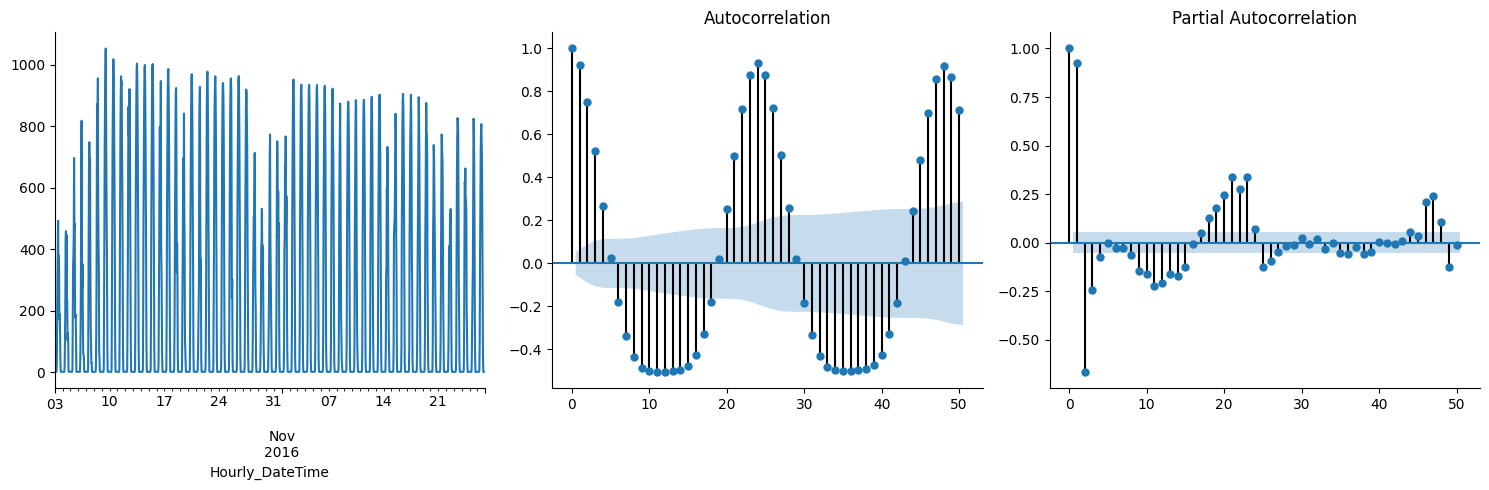

In [ ]:
plots(hourly_radiation_df.Radiation, lags=50)

In [ ]:
# Reset index to simplify making plots
hourly_radiation_reset_df = hourly_radiation_df.reset_index().copy()
hourly_radiation_reset_df.head()

,Hourly_DateTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,ZenithDeviation,Year,Month,Day,Hour,Log_Radiation
0,2016-10-03 00:00:00,1.25,50.00,30.44,102.00,118.59,3.12,697.67,2016,10,3,0,0.22
1,2016-10-03 01:00:00,1.23,49.75,30.44,102.00,107.76,4.12,643.50,2016,10,3,1,0.20
2,2016-10-03 02:00:00,1.24,48.67,30.43,102.00,127.88,3.00,583.50,2016,10,3,2,0.21
3,2016-10-03 03:00:00,1.22,47.08,30.42,101.50,133.17,4.59,523.50,2016,10,3,3,0.20
4,2016-10-03 04:00:00,1.23,48.17,30.42,96.08,148.08,7.03,463.50,2016,10,3,4,0.21


############################################################ SARIMAX model ############################################################ 




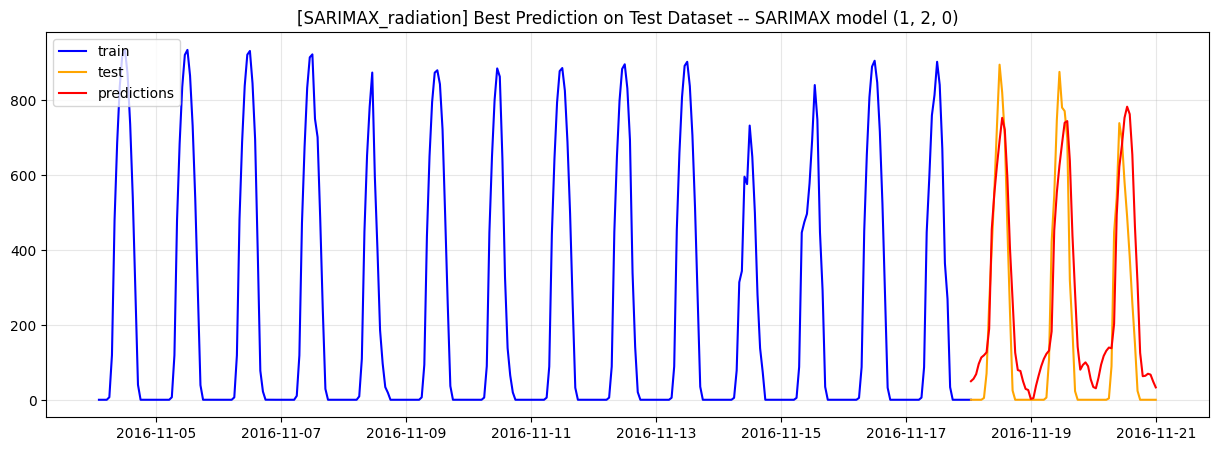

############################################################ SARIMAX model ############################################################ 




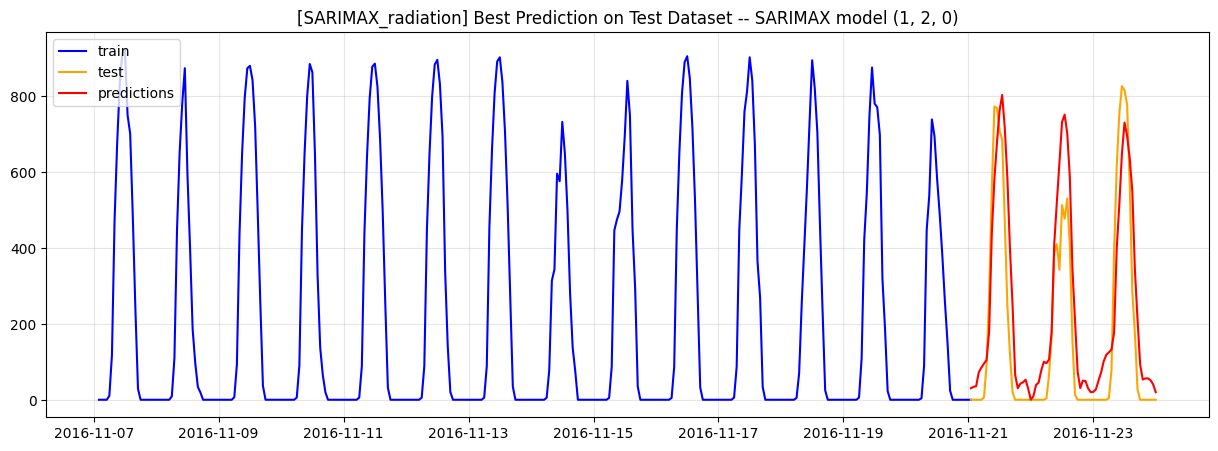

############################################################ SARIMAX model ############################################################ 




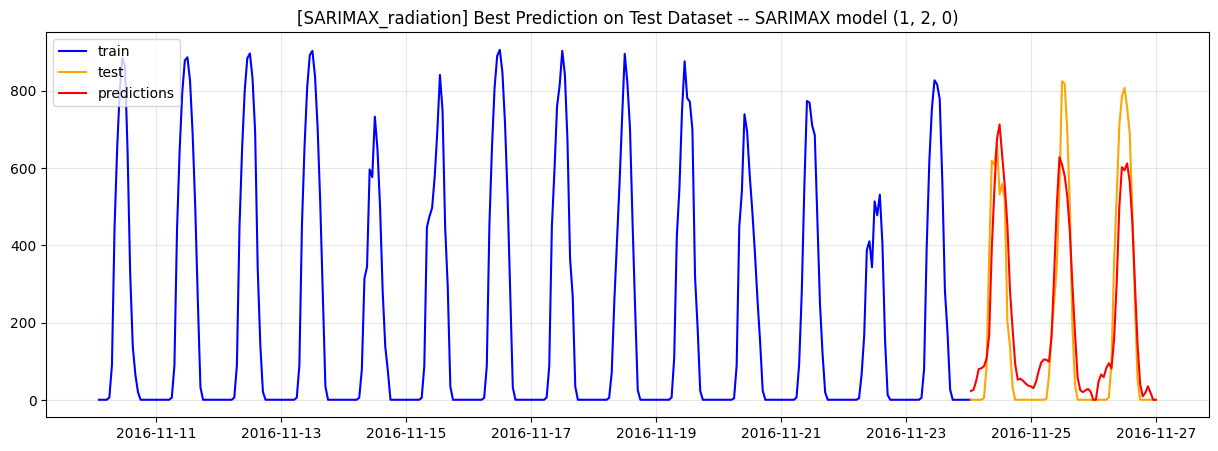

,Iteration,Stationary_Series_Name,Model_Name,Model_Params,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,SARIMAX_radiation,SARIMAX model,"(1, 2, 0)",30.892324,30.809696,145.771188
1,2,SARIMAX_radiation,SARIMAX model,"(1, 2, 0)",22.245987,22.174011,130.323916
2,3,SARIMAX_radiation,SARIMAX model,"(1, 2, 0)",18.505179,18.381112,107.051091


In [ ]:
SARIMAX_results_df = test_SARIMAX_model(hourly_radiation_reset_df, hourly_radiation_reset_df['Radiation'], 'SARIMAX_radiation',
                                        show_plots=False, debug_mode=False)
SARIMAX_results_df

<a id='section_3'></a>
## Section 3. Validate DL and ML models

In [ ]:
def return_to_initial_series_decomposed(best_model_prediction, len_train_set, model_params, stationary_series_name,
                                        model_name, show_plots):
    start_idx = len_train_set
    end_idx = len_train_set + FORECAST_PERIOD

    if 'additive' in stationary_series_name:
        model_prediction_initial_series = \
          best_model_prediction +\
          data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].values +\
          data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]
    else:
        model_prediction_initial_series = \
          best_model_prediction *\
          data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + DECOMPOSED_SHIFT: end_idx + DECOMPOSED_SHIFT].values *\
          data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]

    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    model_forecast_accuracy = forecast_accuracy(model_prediction_initial_series,
                                                hourly_radiation_reset_df['Radiation'][start_idx: end_idx].to_numpy())
    print('Order -- ', model_params)
    pprint(model_forecast_accuracy)

    return model_prediction_initial_series, model_forecast_accuracy


In [ ]:
def fit_SimpleRNN_features(train_X, train_y, validate_X, validate_y, params, is_test_model):
    """

    Fit SimpleRNN to data train_X, train_y with features

    """
    hidden_units, batch_size, epochs = params

    # initialize model
    model = Sequential()

    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(SimpleRNN(hidden_units, input_shape=(train_X.shape[1], 1)))
    model.add(Dropout(0.2))

    # add an output layer to make final forecast
    model.add(Dense(1, activation='relu'))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit network
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    if is_test_model == False:
        history = model.fit(train_X, train_y,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(validate_X, validate_y),
                            verbose=0, shuffle=False)

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(history.history['val_loss'])
        print('Best validation loss of epoch:', validation_loss)

    else:
        model.fit(train_X, train_y,
                    epochs=epochs, batch_size=batch_size,
                    verbose=0, shuffle=False)

    return model


def fit_LSTM_features(train_X, train_y, validate_X, validate_y, params, is_test_model):
    """

    Fit LSTM to data train_X, train_y

    """
    hidden_units, batch_size, epochs = params

    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit network
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    if is_test_model == False:
        log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        # Set validation_data to analyse train performance
        history = model.fit(train_X, train_y,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(validate_X, validate_y),
                            verbose=0, shuffle=False,
                            callbacks=[tensorboard_callback])

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(history.history['val_loss'][1:])
        print('Best validation loss of epoch:', validation_loss)

    else:
        model.fit(train_X, train_y,
                      epochs=epochs, batch_size=batch_size,
                      verbose=0, shuffle=False)

    return model


In [ ]:
def fit_Conv1d_features(train_X, train_y, validate_X, validate_y, params, is_test_model):
    """

    Fit Conv1d to data train_X, train_y

    """
    filters, batch_size, epochs = params
    optimizer = Adagrad(0.01)

    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=filters, kernel_size=2, activation='relu',
                         input_shape=(train_X.shape[1], train_X.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(50, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mse', optimizer=optimizer)

    # fit network
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    if is_test_model == False:
        history = model_cnn.fit(train_X, train_y,
                                epochs=epochs, batch_size=batch_size,
                                validation_data=(validate_X, validate_y),
                                verbose=0, shuffle=False)

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(history.history['val_loss'][1:])
        print('Best validation loss of epoch:', validation_loss)

    else:
        model_cnn.fit(train_X, train_y,
                      epochs=epochs, batch_size=batch_size,
                      verbose=0, shuffle=False)

    return model_cnn


In [ ]:
def optimize_DL_feature_models(params_list, stationary_series_name, model_name, full_df_split, SCALER, show_plots, debug_mode):
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 100_000
    best_model = dict()

    train, validate, test, train_validate = full_df_split

    train_X, train_y = train[:, :-1], train[:, -1]
    validate_X, validate_y = validate[:, :-1], validate[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_validate_X, train_validate_y = train_validate[:, :-1], train_validate[:, -1]

    if 'LSTM' in model_name:
        # reshape input to be 3D [samples, features, timesteps]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        validate_X = validate_X.reshape((validate_X.shape[0], 1, validate_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        train_validate_X = train_validate_X.reshape((train_validate_X.shape[0], 1, train_validate_X.shape[1]))

    else:
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
        validate_X = validate_X.reshape((validate_X.shape[0], validate_X.shape[1], 1))
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
        train_validate_X = train_validate_X.reshape((train_validate_X.shape[0], train_validate_X.shape[1], 1))

    # find the best params for the model based on validation set
    best_model['params'] = params_list[0]
    for params in params_list:
        if 'Conv1d' in model_name:
            model = fit_Conv1d_features(train_X, train_y, validate_X, validate_y, params, False)
        elif 'LSTM' in model_name:
            model = fit_LSTM_features(train_X, train_y, validate_X, validate_y, params, False)
        else:
            model = fit_SimpleRNN_features(train_X, train_y, validate_X, validate_y, params, False)

        yhat = test_model_with_transform(model, validate_X, model_name, 0)
        model_forecast_accuracy = forecast_accuracy(yhat, validate_y)
        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Params -- ', params)
            pprint(model_forecast_accuracy)

        # weighted_score
        weighted_score = model_forecast_accuracy['3. Root Mean Squared Error (RMSE)']

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['params'] = params
            best_model['prediction'] = yhat
            best_model['model_accuracy'] = model_forecast_accuracy

    # make a prediction
    if 'LSTM' in model_name:
        test_model = fit_LSTM_features(train_validate_X, train_validate_y, None, None, best_model['params'], True)
        yhat = test_model_with_transform(test_model, test_X, model_name, 0)
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    else:
        if 'Conv1d' in model_name:
            test_model = fit_Conv1d_features(train_validate_X, train_validate_y, None, None, best_model['params'], True)
        else:
            test_model = fit_SimpleRNN_features(train_validate_X, train_validate_y, None, None, best_model['params'], True)

        yhat = test_model_with_transform(test_model, test_X, model_name, 0)
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

    if show_plots:
        plt.plot(test_y, color='orange', label="test")
        plt.plot(yhat, color='red', label="forecast")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} on TEST set with params -- {best_model["params"]}')
        plt.grid(alpha=0.3)
        plt.show()

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, yhat), axis=1)
    inv_yhat = SCALER.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # return to initial series
    best_model_test_accuracy = dict()
    best_model_prediction_initial_series = []
    if 'decomposed' in stationary_series_name:
        best_model_prediction_initial_series, best_model_test_accuracy =\
            return_to_initial_series_decomposed(inv_yhat, len(train_validate_y) + MAX_DF_SHIFT, best_model['params'],
                                                stationary_series_name, model_name, show_plots)
    else:
        inv_test_y = np.concatenate( (test_X, test_y.reshape(test_y.shape[0],-1)), axis=1 )
        inv_test_y = SCALER.inverse_transform(inv_test_y)
        inv_test_y = inv_test_y[:,-1]

        best_model_prediction_initial_series = inv_yhat
        best_model_test_accuracy = forecast_accuracy(inv_yhat, inv_test_y)

    # In this project we decided to stay just decomposed stationary series as they showed the best performance during my testing
    # else:
    #     if 'multiplicative' in stationary_series_name:
    #         inv_yhat = np.exp(inv_yhat)
    #
    #     best_model_prediction_initial_series, best_model_test_accuracy =\
    #         return_to_initial_series_additive_differencing(inv_yhat, len(train_validate_y) + MAX_DF_SHIFT, best_model['params'],
    #                                                        stationary_series_name, model_name, show_plots)

    return best_model_prediction_initial_series, best_model['params'], best_model_test_accuracy


In [ ]:
def fit_Random_Forest(params):
    model = RandomForestRegressor(
        n_estimators=params[0],
        max_depth=params[1],
        random_state=0
    )
    return model


def fit_XGBoost(params):
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=params[0],
        max_depth=params[1],
        min_child_weight=params[2]
    )
    return model

In [ ]:
def optimize_ML_feature_models(params_list, stationary_series_name, model_name, full_df_split, SCALER, show_plots, debug_mode):
    """

    Tune ML models on validate set and test on test set
    """
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 10_000_000
    best_model = dict()

    train, validate, test, train_validate = full_df_split

    train_X, train_y = train[:, :-1], train[:, -1]
    validate_X, validate_y = validate[:, :-1], validate[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_validate_X, train_validate_y = train_validate[:, :-1], train_validate[:, -1]

    # find the best params for the model based on validation set
    best_model['params'] = params_list[0]
    for params in params_list:
        if 'Random Forest' in model_name:
            model = fit_Random_Forest(params)
        else:
            model = fit_XGBoost(params)

        model.fit(train_X, train_y)
        yhat = test_model_with_transform(model, validate_X, model_name, 0)
        yhat_2D = yhat[:, np.newaxis]
        model_forecast_accuracy = forecast_accuracy(yhat_2D, validate_y)
        if debug_mode:
            print('\n' * 2, '=' * 20, f'Forecast Accuracy [{model_name}]', '=' * 20)
            print('Params -- ', params)
            pprint(model_forecast_accuracy)

        # weighted_score
        weighted_score = model_forecast_accuracy['3. Root Mean Squared Error (RMSE)']

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['params'] = params
            best_model['prediction'] = yhat
            best_model['model_accuracy'] = model_forecast_accuracy

    # make a prediction
    if 'Random Forest' in model_name:
        test_model = fit_Random_Forest(best_model['params'])
    else:
        test_model = fit_XGBoost(best_model['params'])

    test_model.fit(train_validate_X, train_validate_y)
    yhat = test_model_with_transform(test_model, test_X, model_name, 0)

    if show_plots:
        plt.plot(test_y, color='orange', label="test")
        plt.plot(yhat, color='red', label="forecast")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} on TEST set with params -- {best_model["params"]}')
        plt.grid(alpha=0.3)
        plt.show()

    # invert scaling for forecast
    yhat_2D = yhat[:, np.newaxis]
    inv_yhat = np.concatenate((test_X, yhat_2D), axis=1)
    inv_yhat = SCALER.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # return to initial series
    best_model_test_accuracy = dict()
    best_model_prediction_initial_series = []
    if 'decomposed' in stationary_series_name:
        best_model_prediction_initial_series, best_model_test_accuracy =\
            return_to_initial_series_decomposed(inv_yhat, len(train_validate_y) + MAX_DF_SHIFT, best_model['params'],
                                                stationary_series_name, model_name, show_plots)
    else:
        # invert scaling for text_y
        inv_test_y = np.concatenate( (test_X, test_y.reshape(test_y.shape[0],-1)), axis=1 )
        inv_test_y = SCALER.inverse_transform(inv_test_y)
        inv_test_y = inv_test_y[:,-1]

        best_model_prediction_initial_series = inv_yhat
        best_model_test_accuracy = forecast_accuracy(inv_yhat, inv_test_y)

    return best_model_prediction_initial_series, best_model['params'], best_model_test_accuracy


In [ ]:
def get_best_DL_model(stationary_series_name, full_df_split, SCALER, show_plots, debug_mode):
    # RF_n_estimators = [100, 500, 1000]
    # RF_max_depth = [80, 90, 100]
    # RF_params = [RF_n_estimators, RF_max_depth]
    # RF_params = list(itertools.product(*RF_params))

    # !!!! to reduce time to run this notebook by yourself we left only the best parameters
    RF_params = [[100, 100], [500, 100]]
    best_RF_model_prediction, RF_model_description, RF_forecast_accuracy = optimize_ML_feature_models(RF_params, stationary_series_name,
                                                                                                         'Random Forest model', full_df_split, SCALER,
                                                                                                         show_plots, debug_mode)
  
    # XGB_n_estimators = [100, 500, 1000]
    # XGB_max_depth = [4, 5, 6]
    # XGB_min_child_weight = [1, 2, 4]
    # XGB_params = [XGB_n_estimators, XGB_max_depth, XGB_min_child_weight]
    # XGB_params = list(itertools.product(*XGB_params))
    XGB_params = [[1000, 6, 1], [100, 5, 4], [1000, 4, 4]] # best parameters
    best_XGB_model_prediction, XGB_model_description, XGB_forecast_accuracy = optimize_ML_feature_models(XGB_params, stationary_series_name,
                                                                                                         'XGBoost model', full_df_split, SCALER,
                                                                                                         show_plots, debug_mode)
    
    # RNN_filters_lst = [20, 30, 40]
    # RNN_batch_size_lst = [12, 32, 64]
    # RNN_epochs_lst = [200, 300]
    # RNN_params = [RNN_filters_lst, RNN_batch_size_lst, RNN_epochs_lst]
    # RNN_params = list(itertools.product(*RNN_params))
    RNN_params = [[20, 12, 100]] # best parameters
    best_RNN_model_prediction, RNN_model_description, RNN_forecast_accuracy = optimize_DL_feature_models(RNN_params, stationary_series_name,
                                                                                                          'RNN model', full_df_split, SCALER,
                                                                                                         show_plots, debug_mode)

    # LSTM_units_lst = [20, 30, 40]
    # LSTM_batch_size_lst = [12, 32, 64]
    # LSTM_epochs_lst = [200, 300]
    # LSTM_params = [LSTM_units_lst, LSTM_batch_size_lst, LSTM_epochs_lst]
    # LSTM_params = list(itertools.product(*LSTM_params))
    # LSTM_params = [[20, 12, 100]] # best for each cross-validation iteration
    LSTM_params = [[20, 12, 100], [20, 64, 100]] # best parameters
    best_LSTM_model_prediction, LSTM_model_description, LSTM_forecast_accuracy = optimize_DL_feature_models(LSTM_params, stationary_series_name,
                                                                                                            'LSTM model', full_df_split, SCALER,
                                                                                                             show_plots, debug_mode)

    # Conv1d_filters_lst = [20, 30, 40]
    # Conv1d_batch_size_lst = [12, 32, 64]
    # Conv1d_epochs_lst = [200, 300]
    # Conv1d_params = [Conv1d_filters_lst, Conv1d_batch_size_lst, Conv1d_epochs_lst]
    # Conv1d_params = list(itertools.product(*Conv1d_params))
    Conv1d_params = [[30, 64, 100]] # best parameters
    best_Conv1d_model_prediction, Conv1d_model_description, Conv1d_forecast_accuracy = optimize_DL_feature_models(Conv1d_params, stationary_series_name,
                                                                                                                  'Conv1d model', full_df_split, SCALER,
                                                                                                                  show_plots, debug_mode)

    best_model = {'model_name': None, 'model_prediction': None, 'params': None}
    min_weighted_score = 10_000_000
    for forecast_accuracy, model_name, model_prediction, model_description in\
            [
                (RF_forecast_accuracy, 'Random Forest', best_RF_model_prediction, RF_model_description),
                (XGB_forecast_accuracy, 'XGBoost', best_XGB_model_prediction, XGB_model_description),
                (RNN_forecast_accuracy, 'SimpleRNN', best_RNN_model_prediction, RNN_model_description),
                (LSTM_forecast_accuracy, 'LSTM', best_LSTM_model_prediction, LSTM_model_description),
                (Conv1d_forecast_accuracy, 'Conv1d model', best_Conv1d_model_prediction, Conv1d_model_description),
            ]:
        weighted_score = forecast_accuracy['3. Root Mean Squared Error (RMSE)']

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['model_name'] = model_name
            best_model['model_prediction'] = model_prediction
            best_model['params'] = model_description

            best_model['1. Mean Absolute Percentage Error (MAPE)'] = forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)']
            best_model['2. Mean Percentage Error (MPE)'] = forecast_accuracy['2. Mean Percentage Error (MPE)']
            best_model['3. Root Mean Squared Error (RMSE)'] = forecast_accuracy['3. Root Mean Squared Error (RMSE)']

    return best_model, len(full_df_split[3]) + MAX_DF_SHIFT


In [ ]:
def test_ML_DL_models(df, stationary_series, stationary_series_name, show_plots, debug_mode):
    """
    Find the best ML or DL model based on measures and return a dataframe of accuracy metrics of the top 3 best models
    """
    full_numpy_arrs, SCALER = create_feature_df_for_stationary(df, stationary_series)
    full_df_splits = get_train_validation_test_splits(full_numpy_arrs)

    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Params',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    for i in range(3):
        full_df_split = full_df_splits[i]
        best_model, last_train_set_idx = get_best_DL_model(stationary_series_name, full_df_split, SCALER, show_plots, debug_mode)
        results_df.loc[i] = [i + 1, stationary_series_name,
                             best_model['model_name'], best_model['params'],
                             best_model['1. Mean Absolute Percentage Error (MAPE)'],
                             best_model['2. Mean Percentage Error (MPE)'],
                             best_model['3. Root Mean Squared Error (RMSE)']]

        start_idx = last_train_set_idx
        SHIFT = 0
        end_idx = last_train_set_idx + FORECAST_PERIOD

        # add + 1 to make consistent plot
        before_lag = 14 * 24
        plt.plot(hourly_radiation_reset_df['Hourly_DateTime'][start_idx + SHIFT + 1 - before_lag: start_idx + SHIFT + 1], 
                 hourly_radiation_reset_df['Radiation'][start_idx + SHIFT + 1 - before_lag: start_idx + SHIFT + 1], color='blue', label="train")
        plt.plot(hourly_radiation_reset_df['Hourly_DateTime'][start_idx + SHIFT: end_idx + SHIFT],
                 hourly_radiation_reset_df['Radiation'][start_idx + SHIFT: end_idx + SHIFT], color='orange', label="test")
        plt.plot(hourly_radiation_reset_df['Hourly_DateTime'][start_idx + SHIFT: end_idx + SHIFT],
                 best_model['model_prediction'], color='red', label="forecast")
        plt.legend(loc='upper left')
        plt.title(f'[{stationary_series_name}] Best Prediction on Test Dataset -- {best_model["model_name"]} {best_model["params"]}')
        plt.grid(alpha=0.3)
        plt.show()

    return results_df

############################################################ Random Forest model ############################################################ 


############################################################ XGBoost model ############################################################ 


############################################################ RNN model ############################################################ 


Best validation loss of epoch: 0.002874172292649746
############################################################ LSTM model ############################################################ 


Best validation loss of epoch: 0.0027729070279747248
Best validation loss of epoch: 0.0020938508678227663
############################################################ Conv1d model ############################################################ 


Best validation loss of epoch: 0.0028262503910809755


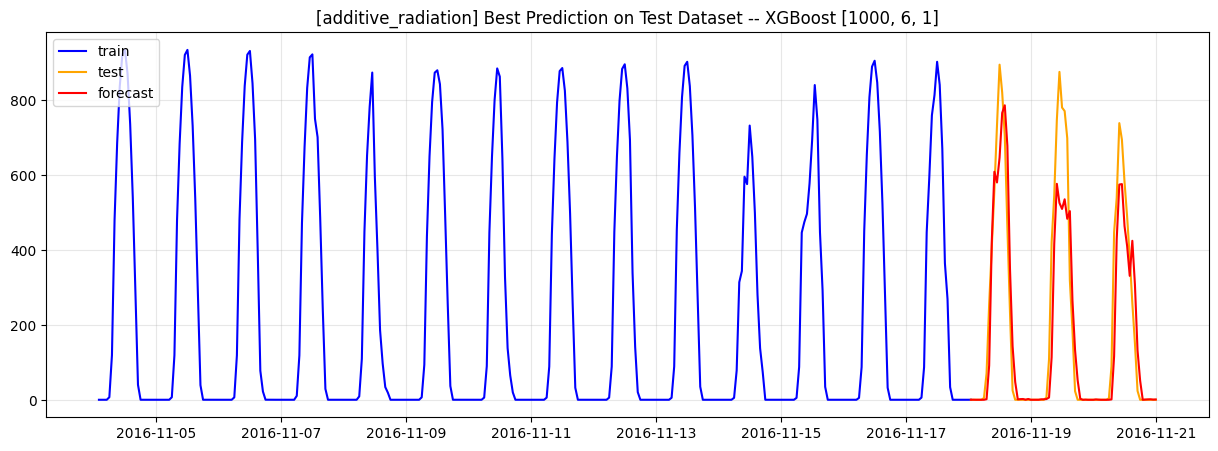

############################################################ Random Forest model ############################################################ 


############################################################ XGBoost model ############################################################ 


############################################################ RNN model ############################################################ 


Best validation loss of epoch: 0.002656243508681655
############################################################ LSTM model ############################################################ 


Best validation loss of epoch: 0.0031109643168747425
Best validation loss of epoch: 0.0026724154595285654
############################################################ Conv1d model ############################################################ 


Best validation loss of epoch: 0.0040074242278933525


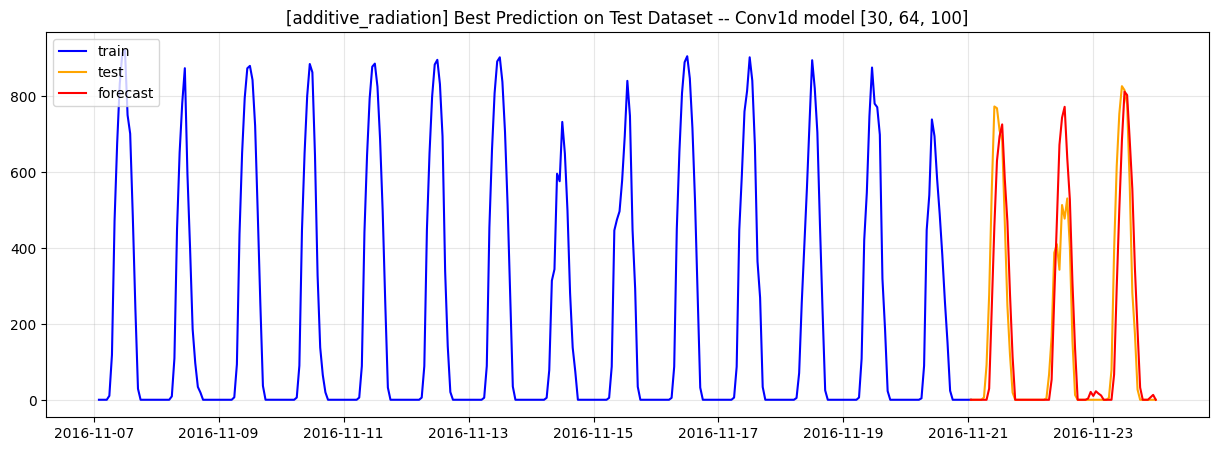

############################################################ Random Forest model ############################################################ 


############################################################ XGBoost model ############################################################ 


############################################################ RNN model ############################################################ 


Best validation loss of epoch: 0.002811354584991932
############################################################ LSTM model ############################################################ 


Best validation loss of epoch: 0.0027123261243104935
Best validation loss of epoch: 0.0032612569630146027
############################################################ Conv1d model ############################################################ 


Best validation loss of epoch: 0.005609768442809582


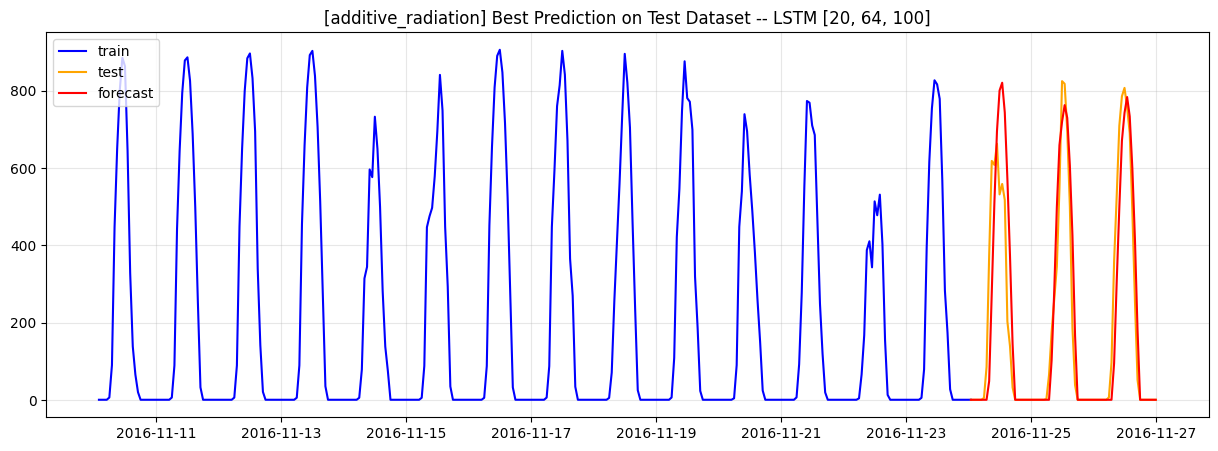

,Iteration,Stationary_Series_Name,Model_Name,Model_Params,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,additive_radiation,XGBoost,"[1000, 6, 1]",2.310567,2.009545,115.834545
1,2,additive_radiation,Conv1d model,"[30, 64, 100]",2.110592,1.810637,127.612574
2,3,additive_radiation,LSTM,"[20, 64, 100]",0.378193,0.102287,119.466705


In [ ]:
ML_DL_models_results_df = test_ML_DL_models(hourly_radiation_df, hourly_radiation_df['Radiation'], 'additive_radiation',
                                            show_plots=False, debug_mode=False)
ML_DL_models_results_df

############################################################ Random Forest model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [500, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 0.17427914116905546,
 '2. Mean Percentage Error (MPE)': 0.011060900634748787,
 '3. Root Mean Squared Error (RMSE)': 95.43203343620881}
############################################################ XGBoost model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [1000, 4, 4]
{'1. Mean Absolute Percentage Error (MAPE)': 0.18065642495237375,
 '2. Mean Percentage Error (MPE)': -0.0015951410517458767,
 '3. Root Mean Squared Error (RMSE)': 93.6203139160901}
############################################################ RNN model ############################################################ 


Best validation loss of ep

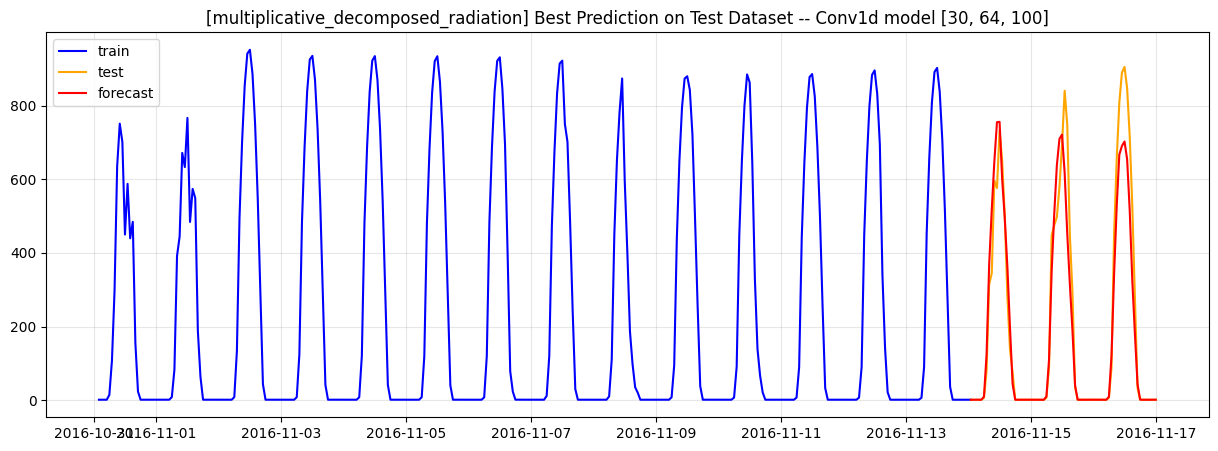

############################################################ Random Forest model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 0.18069375920271294,
 '2. Mean Percentage Error (MPE)': 0.016661858305776975,
 '3. Root Mean Squared Error (RMSE)': 93.16945804247106}
############################################################ XGBoost model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [1000, 4, 4]
{'1. Mean Absolute Percentage Error (MAPE)': 0.1874134800343769,
 '2. Mean Percentage Error (MPE)': 0.009394522899266356,
 '3. Root Mean Squared Error (RMSE)': 92.33257783906342}
############################################################ RNN model ############################################################ 


Best validation loss of epoc

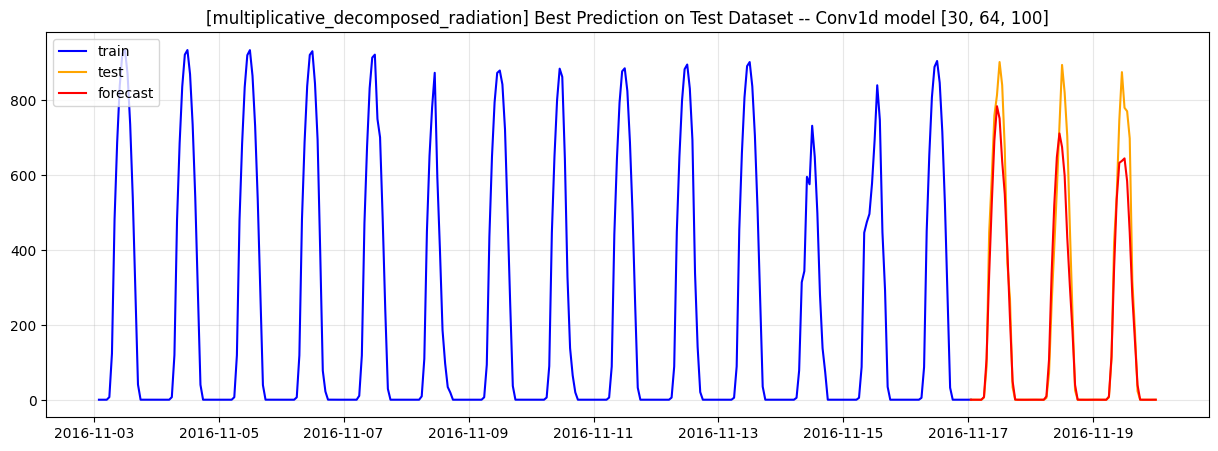

############################################################ Random Forest model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 0.2360555808634611,
 '2. Mean Percentage Error (MPE)': 0.14619498113380397,
 '3. Root Mean Squared Error (RMSE)': 73.02007206946779}
############################################################ XGBoost model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 5, 4]
{'1. Mean Absolute Percentage Error (MAPE)': 0.23801402246296327,
 '2. Mean Percentage Error (MPE)': 0.14926299922491093,
 '3. Root Mean Squared Error (RMSE)': 70.73523177718353}
############################################################ RNN model ############################################################ 


Best validation loss of epoch: 

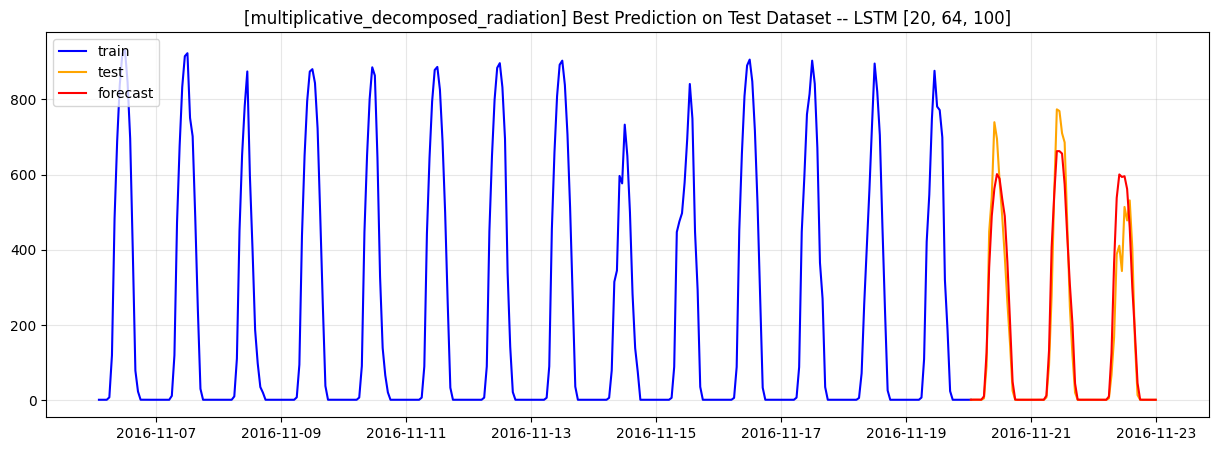

,Iteration,Stationary_Series_Name,Model_Name,Model_Params,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,multiplicative_decomposed_radiation,Conv1d model,"[30, 64, 100]",0.170361,0.001025,87.861467
1,2,multiplicative_decomposed_radiation,Conv1d model,"[30, 64, 100]",0.165759,-0.022066,85.411836
2,3,multiplicative_decomposed_radiation,LSTM,"[20, 64, 100]",0.265516,0.217952,69.375022


In [ ]:
multiplicative_ML_DL_results_df = test_ML_DL_models(hourly_radiation_df[DECOMPOSED_SHIFT: -DECOMPOSED_SHIFT], 
                                                    multiplicative_decomposed_radiation, 'multiplicative_decomposed_radiation',
                                                    show_plots=False, debug_mode=False)
multiplicative_ML_DL_results_df

############################################################ Random Forest model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [500, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 21.179110684880456,
 '2. Mean Percentage Error (MPE)': 20.475061738176894,
 '3. Root Mean Squared Error (RMSE)': 118.56986205522799}
############################################################ XGBoost model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [1000, 6, 1]
{'1. Mean Absolute Percentage Error (MAPE)': 23.159980259600555,
 '2. Mean Percentage Error (MPE)': 23.132916403034695,
 '3. Root Mean Squared Error (RMSE)': 123.10063790040161}
############################################################ RNN model ############################################################ 


Best validation loss of epoch: 

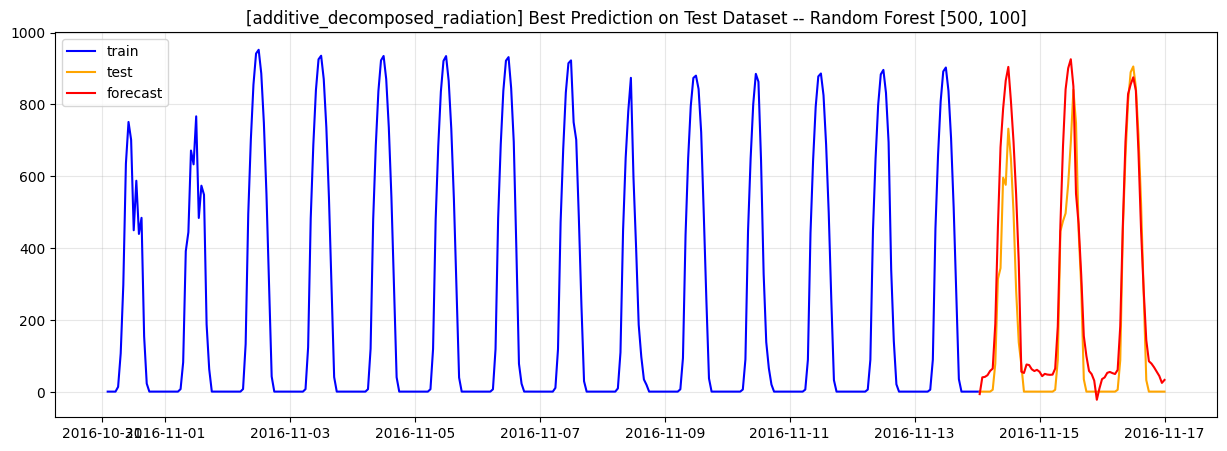

############################################################ Random Forest model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [500, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 13.297740067988903,
 '2. Mean Percentage Error (MPE)': 9.470024329487485,
 '3. Root Mean Squared Error (RMSE)': 66.00378305660037}
############################################################ XGBoost model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [100, 5, 4]
{'1. Mean Absolute Percentage Error (MAPE)': 9.374476597745058,
 '2. Mean Percentage Error (MPE)': 3.548880571064883,
 '3. Root Mean Squared Error (RMSE)': 66.67530822065439}
############################################################ RNN model ############################################################ 


Best validation loss of epoch: 0.0041

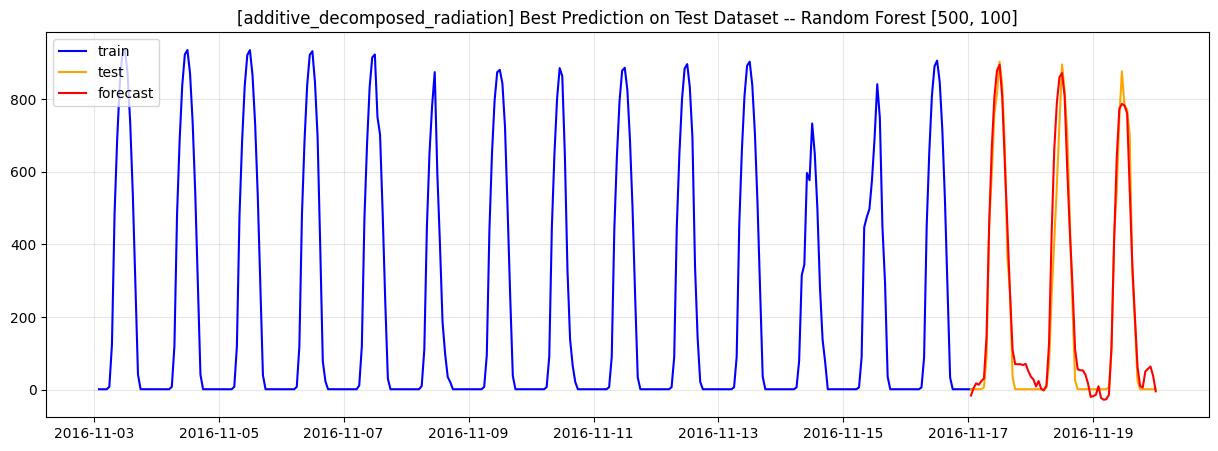

############################################################ Random Forest model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [500, 100]
{'1. Mean Absolute Percentage Error (MAPE)': 11.737884865427523,
 '2. Mean Percentage Error (MPE)': 6.6008085441546145,
 '3. Root Mean Squared Error (RMSE)': 137.42247993685143}
############################################################ XGBoost model ############################################################ 




 ==================== Forecast Accuracy on Test Set ====================
Order --  [1000, 6, 1]
{'1. Mean Absolute Percentage Error (MAPE)': 10.213459908150584,
 '2. Mean Percentage Error (MPE)': 2.36038251201683,
 '3. Root Mean Squared Error (RMSE)': 129.09778694884287}
############################################################ RNN model ############################################################ 


Best validation loss of epoch: 0.

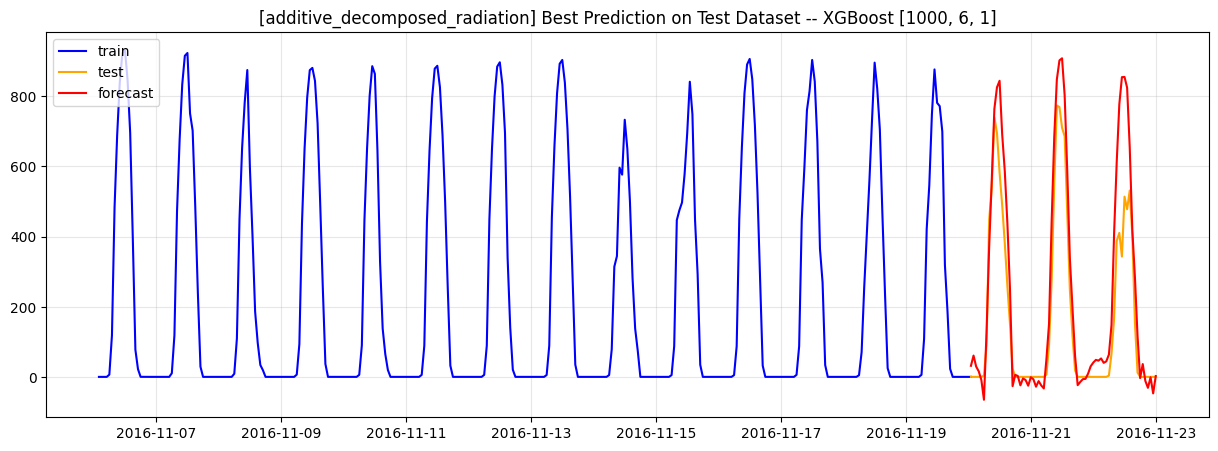

,Iteration,Stationary_Series_Name,Model_Name,Model_Params,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,additive_decomposed_radiation,Random Forest,"[500, 100]",21.179111,20.475062,118.569862
1,2,additive_decomposed_radiation,Random Forest,"[500, 100]",13.297740,9.470024,66.003783
2,3,additive_decomposed_radiation,XGBoost,"[1000, 6, 1]",10.213460,2.360383,129.097787


In [ ]:
additive_ML_DL_results_df = test_ML_DL_models(hourly_radiation_df[DECOMPOSED_SHIFT: -DECOMPOSED_SHIFT], 
                                              additive_decomposed_radiation, 'additive_decomposed_radiation',
                                              show_plots=False, debug_mode=False)
additive_ML_DL_results_df

### Best Forcasts of AR, MA, ARMA and ARIMA models (based on Cross-Validation)

In [ ]:
total_results_df = pd.concat([
    SARIMAX_results_df,
    ML_DL_models_results_df,
    multiplicative_ML_DL_results_df,
    additive_ML_DL_results_df
])
total_results_df

,Iteration,Stationary_Series_Name,Model_Name,Model_Params,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,SARIMAX_radiation,SARIMAX model,"(1, 2, 0)",30.892324,30.809696,145.771188
1,2,SARIMAX_radiation,SARIMAX model,"(1, 2, 0)",22.245987,22.174011,130.323916
2,3,SARIMAX_radiation,SARIMAX model,"(1, 2, 0)",18.505179,18.381112,107.051091
0,1,additive_radiation,XGBoost,"[1000, 6, 1]",2.310567,2.009545,115.834545
1,2,additive_radiation,Conv1d model,"[30, 64, 100]",2.110592,1.810637,127.612574
2,3,additive_radiation,LSTM,"[20, 64, 100]",0.378193,0.102287,119.466705
0,1,multiplicative_decomposed_radiation,Conv1d model,"[30, 64, 100]",0.170361,0.001025,87.861467
1,2,multiplicative_decomposed_radiation,Conv1d model,"[30, 64, 100]",0.165759,-0.022066,85.411836
2,3,multiplicative_decomposed_radiation,LSTM,"[20, 64, 100]",0.265516,0.217952,69.375022
0,1,additive_decomposed_radiation,Random Forest,"[500, 100]",21.179111,20.475062,118.569862


In [ ]:
total_results_df.to_csv(os.path.join('..', 'results', 'ML_DL_models_result_accuracy.csv'),
                        sep=",", columns=total_results_df.columns, float_format="%.2f")

### Conclusion

From the logs of metrics and above dataframe for stationary time series **Conv1d** model showed the best result, since its average RMSE is the smallest one. Also it shows good performance on non-stationary time series and becomes the best on stationary time series based on multiplicative decomposition.

**Best results on one of the folds**

| Stationary_Series_Name | Model_Name | Model_Params  | Mean Absolute Percentage Error (MAPE) | Mean Percentage Error (MPE) | Root Mean Squared Error (RMSE) |
|------------------------| ----------- |---------------| ----------- | ----------- | ----------- |
| multiplicative_decomposed_radiation      | Conv1d model | [30, 64, 100] | 0.239 | 0.1516 | 70.737 |


**Average results on all 3 folds**

| Stationary_Series_Name | Model_Name | Model_Params  | Mean Absolute Percentage Error (MAPE) | Mean Percentage Error (MPE) | Root Mean Squared Error (RMSE) |
|------------------------| ----------- |---------------| ----------- | ----------- | ----------- |
| multiplicative_decomposed_radiation      | Conv1d model | [30, 64, 100] | 0.191 | 0.0582 | 81.34 |

|

-----------------------

**LSTM** gets the second place

**Best results on one of the folds**

| Stationary_Series_Name | Model_Name | Model_Params  | Mean Absolute Percentage Error (MAPE) | Mean Percentage Error (MPE) | Root Mean Squared Error (RMSE) |
|------------------------| ----------- |---------------| ----------- | ----------- | ----------- |
| multiplicative_decomposed_radiation      | LSTM | [20, 64, 100] | 0.2655 | 0.218 | 69.375 |


**Average results on all 3 folds**

| Stationary_Series_Name | Model_Name | Model_Params  | Mean Absolute Percentage Error (MAPE) | Mean Percentage Error (MPE) | Root Mean Squared Error (RMSE) |
|------------------------| ----------- |---------------| ----------- | ----------- | ----------- |
| multiplicative_decomposed_radiation      | LSTM | [20, 64, 100] | 0.215 | 0.10 | 90.79 |

In [ ]:
def get_train_validation_test_splits_for_final_test(np_array):
    df_length = np_array.shape[0]
    validate_length = FORECAST_PERIOD # also equal to test length
    train_length = df_length - 2 * validate_length

    test = np_array[train_length + validate_length: train_length + 2 * validate_length, :]
    test_X, test_y = test[:, :-1], test[:, -1]
    full_df_X, full_df_y = np_array[:, :-1], np_array[:, -1]

    return [(test_X, test_y), (full_df_X, full_df_y)]


def retrain_model_on_full_df(original_df, stationary_series, best_model_params):
    full_df, SCALER = create_feature_df_for_stationary(original_df, stationary_series)
    test, full_df_split = get_train_validation_test_splits_for_final_test(full_df)
    test_X, test_y = test
    full_df_X, full_df_y = full_df_split

    # reshape input to be 3D [samples, timesteps, features]
    full_df_X = full_df_X.reshape((full_df_X.shape[0], full_df_X.shape[1], 1))

    custom_model = fit_Conv1d_features(full_df_X, full_df_y, None, None, best_model_params, True)
    return custom_model, SCALER

In [ ]:
# Retrain on the full df
custom_model, df_scaler = retrain_model_on_full_df(hourly_radiation_df[DECOMPOSED_SHIFT: -DECOMPOSED_SHIFT], multiplicative_decomposed_radiation, [30, 64, 100])

In [ ]:
# For Google Colab
!pip install joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import joblib

# Save scaler for usage for future forecast, which is out of dataframe
joblib.dump(df_scaler, GCOLAB_HOME_DIR + '/results/df_scaler_v3.pkl')

['/content/drive/MyDrive/Colab Notebooks/UCU_ML_2022/UCU_Machine_Learning_Course_Project/results/df_scaler_v3.pkl']

In [ ]:
# Save the best model in files to productize it
custom_model_json = custom_model.to_json()
dir_path = '/content/drive/MyDrive/Colab Notebooks/UCU_ML_2022/UCU_Machine_Learning_Course_Project/results/'
with open(dir_path + 'custom_model_v3.json', 'w') as json_file:
    json_file.write(custom_model_json)
custom_model.save_weights(dir_path + 'custom_model_weights_v3.h5')
custom_model.save(dir_path + 'custom_model_v3.h5')